# Data Aggregation

## Importing Essential Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

## Loading Agriculture Data

In [209]:
maize_data_path = "../data/raw/yield_maize.tif"
soybean_data_path = "../data/raw/yield_soybean.tif"
with rio.open(maize_data_path) as src:
    maize_data = src.read()
maize_data = np.squeeze(maize_data)

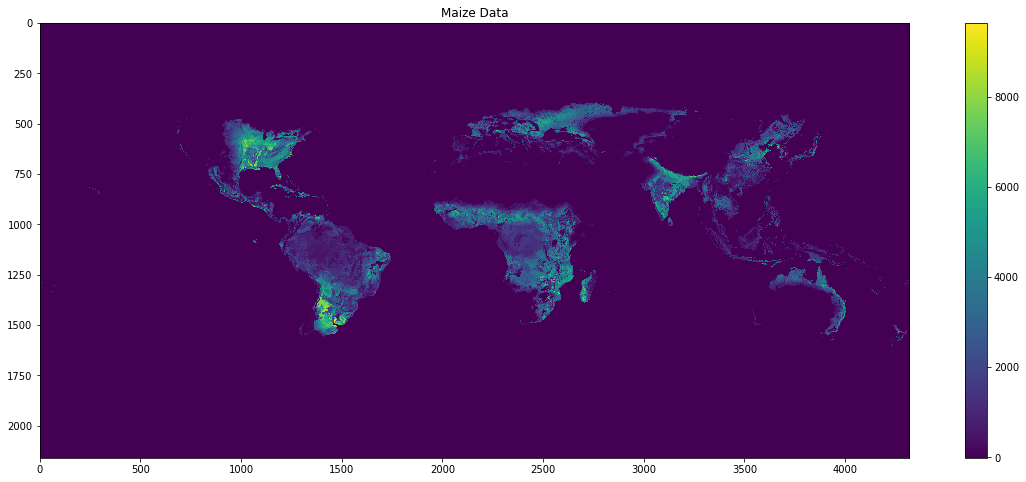

In [3]:
plt.figure(figsize = (20, 8))
plt.title("Maize Data")
plt.imshow(maize_data)
plt.colorbar()
plt.show()

In [4]:
maize_data.shape

(2160, 4320)

In [57]:
lat_index = np.arange(0, maize_data.shape[0])
long_index = np.arange(0, maize_data.shape[1])

long_grid, lat_grid = np.meshgrid(long_index, lat_index)
lat_grid_flat = lat_grid.flatten()
long_grid_flat = long_grid.flatten()

In [60]:
A = src.transform
long, lat = rio.transform.xy(A, lat_grid_flat, long_grid_flat)

In [64]:
lat = np.array(lat).reshape(maize_data.shape)
long = np.array(long).reshape(maize_data.shape)
print((lat.min(), lat.max()))
print((long.min(), long.max()))

(-89.95833333333333, 89.95833333333333)
(-179.95833333333334, 179.9583333333333)


In [196]:
def pix_in_coords(data, lat, long, target_coords = (0, 0), length = 10):
    # latitude/longitude variables
    lat_max = target_coords[0]
    lat_min = lat_max - length
    long_min = target_coords[1]
    long_max = long_min + length
    
    # length variables
    xlen = data.shape[1]
    ylen = data.shape[0]
    
    # find xmin and xmax
    xmin, xmax = None, None
    for x in range(xlen):
        if long[0, x] > long_min:
            xmin = x if xmin == None else xmin
        if long[0, xlen - x - 1] < long_max:
            xmax = xlen - x - 1 if xmax == None else xmax
            
    # find ymin and ymax
    ymin, ymax = None, None
    for y in range(ylen):
        if lat[ylen - y - 1, 0] > lat_min:
            ymin = ylen - y - 1 if ymin == None else ymin
        if lat[y, 0] < lat_max:
            ymax = y if ymax == None else ymax
            
    # index data from top-bottom, left-right
    return data[ymax:ymin, xmin:xmax]

In [197]:
# 10S60W
target_coords = (-10, -60)
seg = pix_in_coords(maize_data, lat, long, target_coords, 10) 

In [203]:
# Loading deforestation data
defor_img_path = "../data/raw/10S60W.tif"
with rio.open(defor_img_path) as src:
    defor_data = src.read()
defor_data = np.squeeze(defor_data)
defor_array = np.array(defor_data)

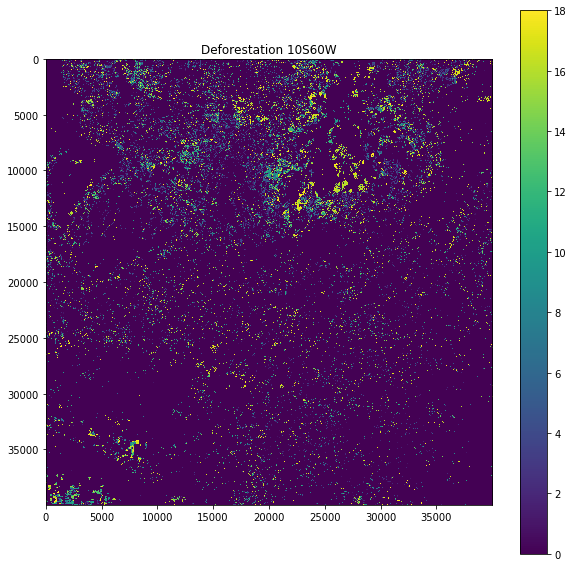

In [208]:
# Plot deforestation data
plt.figure(figsize = (10, 10))
plt.title("Deforestation 10S60W")
plt.imshow(defor_array)
plt.colorbar()
plt.show()

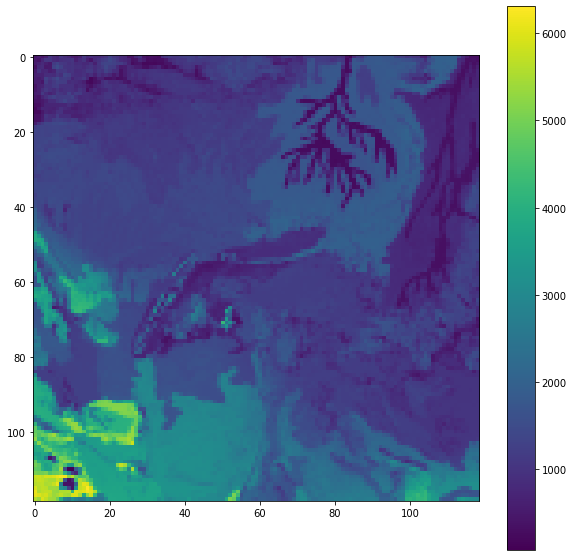

In [212]:
plt.figure(figsize = (10, 10))
plt.imshow(seg)
plt.colorbar()
plt.show()